In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [2]:
'''
Loading
'''

atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

graph_all = nice.graph.graph_from_json('Data/graph_100k.json')
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')
graph_nacs = nice.graph.graph_from_json('Data/graph_nacs_100k.json')

paths_all = json.load(open('Data/paths_100k.json', 'r'))
paths_ccs = json.load(open('Data/paths_ccs_100k.json', 'r'))
paths_nacs = json.load(open('Data/paths_nacs_100k.json', 'r'))

In [3]:
'''
Selecting
'''

graph = graph_ccs
paths = paths_ccs

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']

paths = [p for p in paths if len(p['path']) > 2]

places = [k for k, n in graph._node.items() if 'station' not in k]
stations = [k for k, n in graph._node.items() if 'station' in k]

In [4]:
threshold = 20 * 60

local_stations = []

for source in places:
    for target in stations:
        if graph._adj[source].get(target, {'cost': np.inf})['cost'] <= threshold:

            local_stations.append(target)

In [5]:
'''
Setting travel demand
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
}

graph = nice.demand.demand(graph, places, **kw)

In [6]:
'''
Adding charging information at stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
rho = np.concatenate(
    (
        np.linspace(0, .5, 2),
        np.linspace(.51, .99, 10),
        np.linspace(.991, .999, 10)
    )
)

delta = 100

for station in stations:

    node = graph._node[station]

    power = node['power_kw'] * 1e3
    # power = 80e3
    # print(power)
    m = 1 / (energy / power)
    n = node['port_count']
    # n = 10

    lower_bound = n
    upper_bound = n + delta if n > 3 else n
    # upper_bound = n + delta
    c = list(range(lower_bound, upper_bound + 1, 5))
    # print(c)
    
    # c = [n]
    queue = nice.queue.Queue(m = m, rho = rho, c = c)
    
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    counts = np.array([c for c in c])
    expenditure = np.array([c - n for c in c])
    base_volume = (
        .5 * volumes[0].max() * (station in local_stations)
    )

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * 3600 / (1 / volumes))
    graph._node[station]['counts'] = counts
    graph._node[station]['expenditures'] = expenditure
    graph._node[station]['base_volume'] = 0

    # print(graph._node[station]['delays'][0][-1])

In [7]:
'''
Adding classes and Building the network
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']
        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Objects Built: 2.948293924331665
Sets Built: 0.06484031677246094
Parameters Built: 0.957275390625
Variables Built: 0.5750348567962646
Constraints Built: 0.7697227001190186
Expenditure Built: 0.052344322204589844
Objective Built: 0.12886714935302734


In [8]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 0

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 1.901599407196045
Results Collected: 0.5214214324951172
Objective Value: 0.5245146238308895


In [9]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        # 'time_limit': 60 * 10,
    },
}

scale = 2e4
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 100

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')

graph_out = graph_ccs

for k, n in graph_out._node.items():
    if 'port_count' in n:
        
        n['delta'] = solution._node[k]['selection'] - n['port_count']
        n['port_count'] = solution._node[k]['selection']

nice.graph.graph_to_json(graph_out, 'Data/graph_ccs_100u.json')

Problem Solved: 467.2827706336975
Results Collected: 0.5687196254730225
Objective Value: 0.37637819606145684


In [175]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 25

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 64.24417185783386
Results Collected: 1.9674263000488281
Objective Value: 0.38205611570984127


In [162]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 50

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 41.996870040893555
Results Collected: 0.5208024978637695
Objective Value: 0.3779676003061016


In [159]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 100

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 87.45254158973694
Results Collected: 0.5345520973205566
Objective Value: 0.3774679345696323


In [160]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4 * 1
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 300

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 43.268399477005005
Results Collected: 0.5212085247039795
Objective Value: 0.3774675720928836


In [161]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4 * 1
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 600

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 18.56053614616394
Results Collected: 0.5080430507659912
Objective Value: 0.37746756772480133


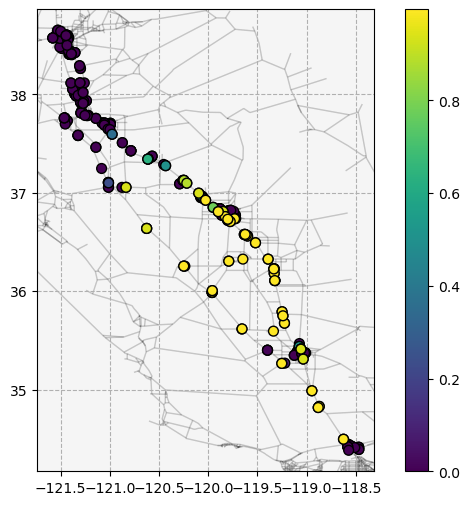

In [165]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for station in stations:
    
    node = solution._node[station]

    node['volume_h'] = node.get('volume', 0) * 3600
    # node['delay_ind'] = node.get('delay', 1) / max([node.get('volume', 0), .0000001])
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)
    # node['optimal_ports'] = node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['delta'] > 0]
        ),
        'selection': stations,
        'field': 'port_count',
        'field': 'volume_h',
        'field': 'delay',
        'field': 'utilization',
        # 'field': 'delta',
        # 'field': 'selection',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

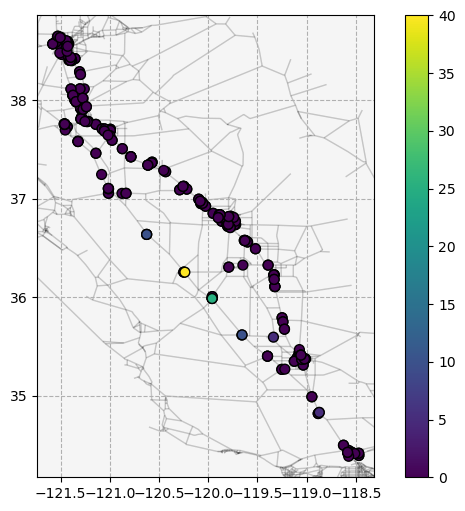

In [181]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for station in stations:
    
    node = solution._node[station]

    node['volume_h'] = node.get('volume', 0) * 3600
    # node['delay_ind'] = node.get('delay', 1) / max([node.get('volume', 0), .0000001])
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)
    # node['optimal_ports'] = node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['delta'] > 0]
        ),
        'selection': stations,
        'field': 'port_count',
        'field': 'volume_h',
        'field': 'delay',
        # 'field': 'utilization',
        'field': 'delta',
        # 'field': 'selection',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

In [44]:
total_delay = 0

for station in stations:

    total_delay += solution._node[station]['delay']

total_delay / scale

20.56096467887539

In [45]:
num = sum(
    [n.get('mode_switch', 0) for n in solution._node.values()]
)

den = sum(
    [n.get('total', 0) for n in solution._node.values()]
)

ratio = np.nan_to_num(num / den)

scale, ratio

(5.555555555555555, 0.0)

In [69]:
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')

graph_ccs_300 = graph_ccs

for k, n in graph_ccs_300._node.items():
    if 'port_count' in n:

        n['delta'] = solution._node[k]['selection'] - n['port_count']
        n['port_count'] = solution._node[k]['selection']

nice.graph.graph_to_json(graph_ccs_300, 'Data/graph_ccs_300.json')

sum([n.get('port_count', 0) for n in graph_ccs_300._node.values()])

1329

In [41]:
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')

graph_ccs_200 = graph_ccs

for k, n in graph_ccs_200._node.items():
    if 'port_count' in n:

        n['port_count'] = solution._node[k]['selection']

nice.graph.graph_to_json(graph_ccs_200, 'Data/graph_ccs_200.json')

sum([n.get('port_count', 0) for n in graph_ccs_200._node.values()])

1229

In [66]:
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')

graph_ccs_100 = graph_ccs

for k, n in graph_ccs_100._node.items():
    if 'port_count' in n:
        
        n['delta'] = solution._node[k]['selection'] - n['port_count']
        n['port_count'] = solution._node[k]['selection']

nice.graph.graph_to_json(graph_ccs_100, 'Data/graph_ccs_100.json')

sum([n.get('port_count', 0) for n in graph_ccs_100._node.values()])

1129